In [1]:
%load_ext Cython

In [2]:
import numpy as np 

A = np.array([[1, 2, 3], [4, 5, 6]]).astype(np.float64)
B = np.array([[7, 8], [9, 10], [11, 12]]).astype(np.float64)
A,B

(array([[1., 2., 3.],
        [4., 5., 6.]]),
 array([[ 7.,  8.],
        [ 9., 10.],
        [11., 12.]]))

## NUMPY Matrix Multiplication (Naive)

In [3]:
# define naive matrix multiplication in numpy
import numpy as np

def matrix_multiply_npv0(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i, j] += A[i, k] * B[k, j]
    return result


In [4]:

%%time
numpy_result = matrix_multiply_npv0(A, B)

CPU times: user 28 µs, sys: 13 µs, total: 41 µs
Wall time: 43.6 µs


## NUMPY Matrix Multiplication (dot product)

In [5]:
# define naive matrix multiplication in numpy
import numpy as np

def matrix_multiply_npv1(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            result[i, j] = np.dot(A[i, :], B[:, j])
    return result


In [6]:

%%time
numpy_result = matrix_multiply_npv1(A, B)
numpy_result

CPU times: user 0 ns, sys: 309 µs, total: 309 µs
Wall time: 270 µs


array([[ 58.,  64.],
       [139., 154.]])

## NUMPY Matrix Multiplication (vectorized)

In [7]:

%%time
numpy_result_vec = np.matmul(A, B)
numpy_result_vec

CPU times: user 120 µs, sys: 56 µs, total: 176 µs
Wall time: 180 µs


array([[ 58.,  64.],
       [139., 154.]])

## NUMBA Matrix Multiplication

In [8]:
import numba 

@numba.jit(nopython=True)
def matrix_multiply_numba(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i, j] += A[i, k] * B[k, j]
    return result



## First time NUMBA Function is called

In [9]:
%%time
numba_result = matrix_multiply_numba(A, B)
numba_result

CPU times: user 1.36 s, sys: 1.03 s, total: 2.39 s
Wall time: 694 ms


array([[ 58.,  64.],
       [139., 154.]])

## Second time NUMBA Function is called

In [10]:
%%time
numba_result = matrix_multiply_numba(A, B)
numba_result

CPU times: user 17 µs, sys: 10 µs, total: 27 µs
Wall time: 28.8 µs


array([[ 58.,  64.],
       [139., 154.]])

## CYTHON Matrix Multiplication Version 0

In [11]:
%%cython
import numpy as np

def matrix_multiply_cython0(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i, j] += A[i, k] * B[k, j]
    return result



In [12]:
%time 
cython_result = matrix_multiply_cython0(A, B)
cython_result

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


array([[ 58.,  64.],
       [139., 154.]])

## CYTHON Matrix Multiplication Version 1

In [13]:
%%cython
import numpy as np
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.locals(A=cython.double[:, :], B=cython.double[:, :], result=cython.double[:,:], i=cython.int, j=cython.int, k=cython.int)
def matrix_multiply_cython1(A, B):
    result = np.zeros((A.shape[0], B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                result[i, j] += A[i, k] * B[k, j]
    return np.asarray(result)



In [14]:
%time 
cython_result = matrix_multiply_cython1(A, B)
cython_result

CPU times: user 1e+03 ns, sys: 0 ns, total: 1e+03 ns
Wall time: 5.25 µs


array([[ 58.,  64.],
       [139., 154.]])

## CYTHON Matrix Multiplication Version 2

In [15]:
%%cython

import numpy as np

cimport cython
from libc.stdlib cimport calloc

@cython.boundscheck(False)
@cython.wraparound(False)
cpdef matrix_multiply_cython2(double[:, ::1] A, double [:, ::1] B):
    # Declare integer variables for loop counters and matrix dimensions
    cdef int i, j, k
    cdef int nrows_A = len(A)  # Number of rows in matrix A
    cdef int ncols_B = len(B[0])  # Number of columns in matrix B
    cdef int ncols_A = len(A[0])  # Number of columns in matrix A

    # Allocate memory for the result matrix and initialize it with zeros
    cdef double[:,:] result = <double[:nrows_A, :ncols_B]> calloc(nrows_A * ncols_B, sizeof(double))

    # Perform matrix multiplication
    for i in range(nrows_A):  # Iterate over rows of A
        for j in range(ncols_B):  # Iterate over columns of B
            # Compute dot product of i-th row of A and j-th column of B
            for k in range(ncols_A):
                result[i, j] += A[i, k] * B[k, j]

    # Return the result matrix
    return np.asarray(result)

In [16]:
%time 
cython_result2 = matrix_multiply_cython2(A, B)
cython_result2

CPU times: user 1 µs, sys: 1 µs, total: 2 µs
Wall time: 5.72 µs


array([[ 58.,  64.],
       [139., 154.]])

## TAICHI Matrix Multiplication

In [17]:
import taichi as ti

ti.init(arch=ti.cpu)  # Use CPU by default

def matrix_multiply_taichi(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    C = ti.field(shape=(A.shape[0], B.shape[1]), dtype=ti.f64)

    # Convert the numpy arrays to Taichi ndarrays
    A_ti = ti.field(shape=A.shape, dtype=ti.f64)
    B_ti = ti.field(shape=B.shape, dtype=ti.f64)
    A_ti.from_numpy(A)
    B_ti.from_numpy(B)
    sum = ti.field(dtype=ti.f64, shape=())

    @ti.kernel
    def _taichi_compute():
        ti.loop_config(serialize=True)
        for i in range(A.shape[0]):
            for j in range(B.shape[1]):
                sum[None] = 0.0
                for k in range(A.shape[1]):
                    sum[None] += A_ti[i, k] * B_ti[k, j]
                C[i,j] = sum[None]

    _taichi_compute()
    return C.to_numpy()


[Taichi] version 1.7.0, llvm 15.0.4, commit 2fd24490, linux, python 3.10.13


[I 01/11/24 10:32:38.680 1420] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


[Taichi] Starting on arch=x64


In [18]:
%time 
taichi_result = matrix_multiply_taichi(A, B)
taichi_result

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.77 µs


array([[ 58.,  64.],
       [139., 154.]])

In [19]:
%time 
taichi_result = matrix_multiply_taichi(A, B)
taichi_result

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


array([[ 58.,  64.],
       [139., 154.]])

## Large Matrix Multiplication

In [20]:
# list to collect run-time metrics
# initialize with results for native C implementation
test_results = [
    {"function": "native_c", "duration": 0.009, "results": None}
]

DIM_SIZE = 200
np.random.seed(0)
# Create two random square matrices
A = np.random.rand(DIM_SIZE, DIM_SIZE)
B = np.random.rand(DIM_SIZE, DIM_SIZE)
A.shape, B.shape


((200, 200), (200, 200))

In [21]:
%%time
import time
import pandas as pd
import gc

# helper function to test the different implementations of matrix multiplication
def test_function(function, identifier, A, B):
    gc.disable()
    start_time = time.time()
    C = function(A, B)
    end_time = time.time()
    duration = end_time - start_time
    gc.enable()

    return {"function": identifier, "duration": duration, "results": C}


# setup test scenarios
test_scenarios = [
    {"function": matrix_multiply_npv0, "identifier": "numpyv0", "A": A, "B": B},
    {"function": matrix_multiply_npv1, "identifier": "numpyv1", "A": A, "B": B},
    {"function": np.matmul, "identifier": "numpyv2", "A": A, "B": B},
    {"function": matrix_multiply_numba, "identifier": "numba", "A": A, "B": B},
    {"function": matrix_multiply_cython0, "identifier": "cythonv0", "A": A, "B": B},
    {"function": matrix_multiply_cython1, "identifier": "cythonv1", "A": A, "B": B},
    {"function": matrix_multiply_cython2, "identifier": "cythonv2", "A": A, "B": B},
    {"function": matrix_multiply_taichi, "identifier": "taichi", "A": A, "B": B},
]

for t in range(10):
    print(f"starting test run {t}")
    for ts in test_scenarios:
        test_results.append(test_function(ts["function"], ts["identifier"], ts["A"], ts["B"]))


starting test run 0
starting test run 1
starting test run 2
starting test run 3
starting test run 4
starting test run 5
starting test run 6
starting test run 7
starting test run 8
starting test run 9
CPU times: user 1min 22s, sys: 6.07 s, total: 1min 28s
Wall time: 1min 10s


In [22]:
df = pd.DataFrame(test_results)
df


,function,duration,results
0,native_c,0.009000,None
1,numpyv0,3.955670,"[[46.7619035508464, 51.01059403987534, 50.7739..."
2,numpyv1,0.046874,"[[46.76190355084639, 51.010594039875386, 50.77..."
3,numpyv2,0.002115,"[[46.7619035508464, 51.01059403987535, 50.7739..."
4,numba,0.009130,"[[46.7619035508464, 51.01059403987534, 50.7739..."
...,...,...,...
76,numba,0.009718,"[[46.7619035508464, 51.01059403987534, 50.7739..."
77,cythonv0,3.034077,"[[46.7619035508464, 51.01059403987534, 50.7739..."
78,cythonv1,0.008056,"[[46.7619035508464, 51.01059403987534, 50.7739..."
79,cythonv2,0.007425,"[[46.7619035508464, 51.01059403987534, 50.7739..."


In [23]:
df = df.groupby("function").mean().sort_values(by="duration")
df.reset_index(inplace=True)
df.rename(columns={'index': 'function'}, inplace=True)
df['speed_up'] = df[df.function == 'numpyv0'].duration.values[0] / df['duration'] 
df

,function,duration,results,speed_up
0,numpyv2,0.003023,"[[46.7619035508464, 51.01059403987535, 50.7739...",1207.518122
1,cythonv2,0.008081,"[[46.7619035508464, 51.01059403987534, 50.7739...",451.691696
2,cythonv1,0.008506,"[[46.7619035508464, 51.01059403987534, 50.7739...",429.135410
3,native_c,0.009000,NaN,405.557341
4,numba,0.009921,"[[46.7619035508464, 51.01059403987534, 50.7739...",367.909761
5,numpyv1,0.048788,"[[46.76190355084639, 51.01059403987539, 50.773...",74.814212
6,taichi,0.205026,"[[46.76190355084639, 51.01059403987536, 50.773...",17.802663
7,cythonv0,3.097296,"[[46.7619035508464, 51.01059403987534, 50.7739...",1.178453
8,numpyv0,3.650016,"[[46.7619035508464, 51.01059403987534, 50.7739...",1.000000


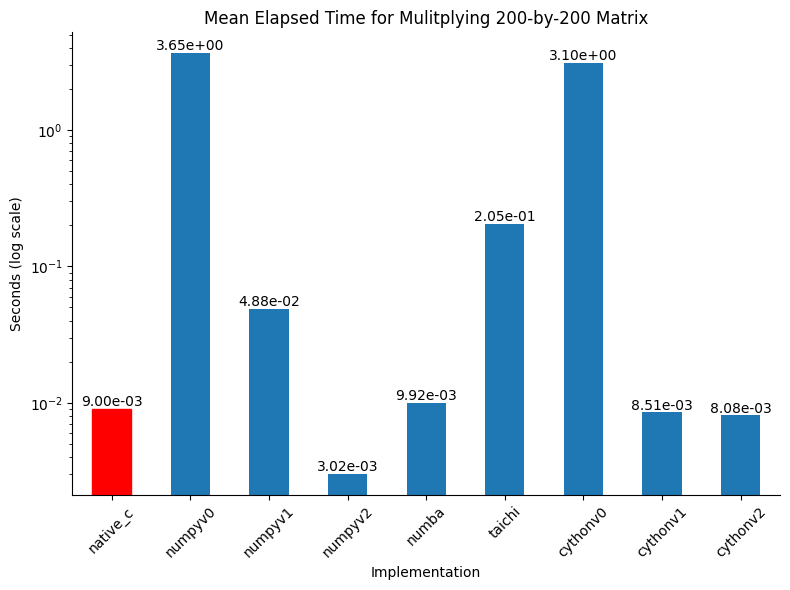

In [24]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))

# Define the desired order
order = ['native_c', 'numpyv0', 'numpyv1', 'numpyv2', 'numba', 'taichi', 'cythonv0', 'cythonv1', 'cythonv2']

# Sort the DataFrame by the 'function' column based on the desired order
df['function'] = df['function'].astype('category')
df['function'] = df['function'].cat.set_categories(order)
df.sort_values('function', inplace=True)

# Plot the data
df.plot(kind='bar', x='function', y='duration', legend=False, ax=ax)

# Change the color of the "native_c" bar to red
for i, bar in enumerate(ax.patches):
    if df['function'].iloc[i] == 'native_c':
        bar.set_color('red')

plt.xlabel('Implementation')
plt.ylabel('Seconds (log scale)')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title(f'Mean Elapsed Time for Mulitplying {DIM_SIZE}-by-{DIM_SIZE} Matrix')

# Add duration values on top of the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2e'), 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'top', 
                xytext = (0, 10), 
                textcoords = 'offset points')
# Remove top and right lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.savefig('matrix_multiply_time.png', dpi=300)
plt.show()

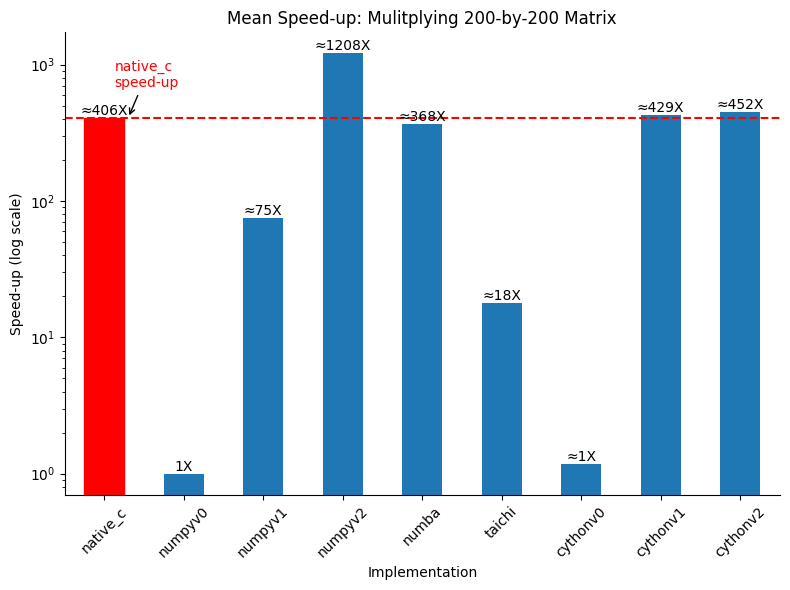

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

# Retrieve speed-up value for "native_c"
speed_up_native_c = df.loc[df['function'] == 'native_c', 'speed_up'].values[0]

# Plot the data
df.plot(kind='bar', x='function', y='speed_up', legend=False, ax=ax)

# Change the color of the "native_c" bar to red
for i, bar in enumerate(ax.patches):
    if df['function'].iloc[i] == 'native_c':
        bar.set_color('red')

# label plot
plt.xlabel('Implementation')
plt.ylabel('Speed-up (log scale)')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.yscale('log')  # Set y-axis to logarithmic scale
plt.title(f'Mean Speed-up: Mulitplying {DIM_SIZE}-by-{DIM_SIZE} Matrix')

# Add duration values on top of the bars
for i, p in enumerate(ax.patches):
    # Use the "equal sign" for "np_hand_coded" and the "approximately equal" sign for all others
    prefix = '' if df['function'].iloc[i] == 'numpyv0' else '≈'
    ax.annotate(prefix + format(p.get_height(), '.0f') + 'X', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'top', 
                xytext = (0, 10), 
                textcoords = 'offset points')

# Draw horizontal reference line at the speed-up value for "native_c"
plt.axhline(y=speed_up_native_c, color='r', linestyle='--')

# Annotate the reference line
plt.annotate('native_c\nspeed-up', xy=(0.3, speed_up_native_c), xytext=(-10, 20), 
             textcoords='offset points', arrowprops=dict(arrowstyle='->'),
             va="bottom", ha="left", color='r')

# Remove top and right lines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()  # Adjust layout to prevent labels from being cut off
plt.savefig('matrix_multiply_speedup.png', dpi=300)
plt.show()